In [1]:
import torch
import numpy as np
import h5py
import sys
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.table import Table
from matplotlib import mlab as mlab
from astroNN.shared.matplotlib import pylab_style
pylab_style(paper=True)

sys.path.append('..')
from xp_vae.model import ScatterVAE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using %s' % device)
torch.cuda.empty_cache()

import matplotlib as mpl

Using cpu


## Load model

In [2]:
from xp_vae.model import ScatterVAE

model = ScatterVAE().to(device)
weights = torch.load('../models/APOGEE_MODEL/weight.pt',map_location=device)
model.load_state_dict(state_dict=weights['model_state_dict'])
model.eval()

ScatterVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=110, out_features=90, bias=True)
      (1): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Sequential(
      (0): Linear(in_features=90, out_features=70, bias=True)
      (1): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (2): Sequential(
      (0): Linear(in_features=70, out_features=50, bias=True)
      (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (3): Sequential(
      (0): Linear(in_features=50, out_features=30, bias=True)
      (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (4): Sequential(
      (0): Linear(in_features=30, out_features=10, bias=True)
      (1): Batc

## Make catalogs

In [3]:
APOGEE_XP_XMATCH_PATH = '../data/xp_apogee_cat.h5'
f = h5py.File(APOGEE_XP_XMATCH_PATH,'r')['__astropy_table__']

# flux normalization
g_flux = f['phot_g_mean_flux'][:,np.newaxis]
xp = f['coeffs']/g_flux
xp_err = f['coeff_errs']/g_flux

# standard normalization
norm = np.load('../data/apogee_norm.npz')
xp_norm = (xp - norm['mu']) / norm['sig']
xp_err_norm = xp_err / norm['sig']

# stellar labels + redenning
teff = f['TEFF']
logg = f['LOGG']
m_h = f['M_H']
logebv = np.log10(f['SFD_EBV'])

# errors
teff_err = f['TEFF_ERR']
logg_err = f['LOGG_ERR']
m_h_err = f['M_H_ERR']

# other data for cuts
bp_rp = f['GAIAEDR3_PHOT_BP_MEAN_MAG'] - f['GAIAEDR3_PHOT_RP_MEAN_MAG']
mean_mag = f['GAIAEDR3_PHOT_G_MEAN_MAG']
starflag = f['STARFLAG']
aspcapflag = f['ASPCAPFLAG']

In [4]:
# GOOD LABELS CATALOG
teff_cut = (teff/teff_err)>20
logg_cut = logg_err<.4
m_h_cut = m_h_err<.2
bp_rp_cut = (bp_rp > 0.) & (bp_rp < 4.)
mag_cut = (mean_mag > 6.) & (mean_mag < 17.5)
star_cut = starflag == 0

from astroNN.apogee import allstar, bitmask_boolean
aspcap_cut = ~bitmask_boolean(aspcapflag, [2, 3])[0]

good_idx = ( teff_cut & logg_cut & m_h_cut & bp_rp_cut & mag_cut & star_cut & aspcap_cut)
print('Size of full catalog is %s' % len(teff))
print('Size of good labels catalog is %s' % sum(good_idx))
print('Good/full = %.2f' % (sum(good_idx)/len(teff)))
print('Teff cut removes %s stars' % sum(~teff_cut))
print('logg cut removes %s stars' % sum(~logg_cut))
print('[M/H] cut removes %s stars' % sum(~m_h_cut))
print('')

# PRISTINE LABELS CATALOG
teff_cut = (teff/teff_err)> 100
logg_cut = logg_err<.1
m_h_cut = m_h_err<.05
pristine_idx = ( teff_cut & logg_cut & m_h_cut & bp_rp_cut & mag_cut & star_cut & aspcap_cut)
print('Size of pristine labels catalog is %s' % sum(pristine_idx))
print('Good/full = %.2f' % (sum(pristine_idx)/len(teff)))
print('Teff cut removes %s stars' % sum(~teff_cut))
print('logg cut removes %s stars' % sum(~logg_cut))
print('[M/H] cut removes %s stars' % sum(~m_h_cut))

Size of full catalog is 502311
Size of good labels catalog is 202970
Good/full = 0.40
Teff cut removes 16028 stars
logg cut removes 43705 stars
[M/H] cut removes 32314 stars

Size of pristine labels catalog is 123804
Good/full = 0.25
Teff cut removes 273466 stars
logg cut removes 286191 stars
[M/H] cut removes 33769 stars


In [5]:
from sklearn.model_selection import train_test_split
validation_split = 0.1 # default value

# split up xp data to match training (see xp_vae.model.fit), by index
idx = np.arange(len(xp))
idx_train,idx_val = train_test_split(idx,test_size=validation_split,random_state=12345)

idx_val_good = np.array([idx for idx in idx_val if good_idx[idx] == True])
idx_val_pristine = np.array([idx for idx in idx_val if pristine_idx[idx] == True])

## Project into latent space

In [6]:
in1 = torch.from_numpy(xp_norm).cpu().to(device)
in2 = torch.from_numpy(xp_err_norm).to(device)

_,_,mu,log_var,est,s = model.forward(in1,in2)

est = est.detach().cpu().numpy()*norm['sig']+norm['mu']
s = s.detach().cpu().numpy()*norm['sig']
latent = model.reparam(mu.cpu().to(device),log_var.cpu().to(device)).cpu().detach().numpy()

## Dwarf/giant tracks

In [7]:
# for visualization purposes, will use good labels catalog

teff_use = teff[good_idx]
logg_use = logg[good_idx]
m_h_use = m_h[good_idx]
latent_use = latent[good_idx]

In [8]:
# dwarf and giant type tracks used by ZGR23 and LB23

logg_unc = 0.2

smd_mask1 = (np.abs(logg_use-4.6)<logg_unc) * (teff_use<5000)
smd_mask2 = (np.abs(logg_use-(4.6-0.0005*(teff_use-5000)))<logg_unc) * (5000<=teff_use)*(teff_use<6300)
smd_mask3 = (np.abs(logg_use-3.95)<logg_unc) * (6300<=teff_use)
smd_mask = smd_mask1 | smd_mask2 | smd_mask3

teff_unc = 100

rgb_mask1 = (np.abs(teff_use - (5200-441.86*(3.65-logg_use)))<logg_unc) * (logg_use<3.65)
rgb_mask2 = (np.abs(teff_use - (5900-1400*(4.15-logg_use)))<logg_unc) * (logg_use>=3.65)
rgb_mask = rgb_mask1 | rgb_mask2

/opt/anaconda3/envs/xp/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/xp/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


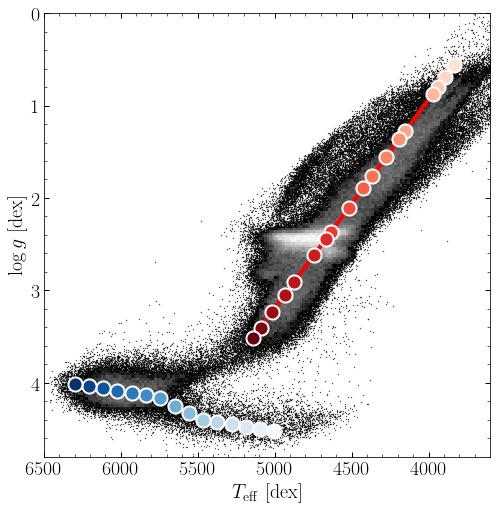

In [9]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

bins=201
s = 200
lw = 2
teff_grid = np.linspace(min(teff_use),max(teff_use),bins)
logg_grid = np.linspace(min(logg_use),max(logg_use),bins)

ax.hist2d(teff_use,logg_use,bins=[teff_grid,logg_grid],cmin=20,norm=colors.PowerNorm(0.5),cmap='Greys_r',zorder=2)
ax.scatter(teff_use,logg_use,s=0.1,color='k',zorder=1)

num_teff = 15
teff_unc = 10
teff_grid = np.linspace(5000,6300,num_teff)
c = np.arange(1,num_teff+1)
cmap = mpl.cm.get_cmap('Blues',num_teff)

x1=[]
y1=[]
for i,teff_i in enumerate(teff_grid):
    mask_i = np.abs(teff_use-teff_i)<10
    ax.scatter(np.mean(teff_use[smd_mask2*mask_i]),np.mean(logg_use[smd_mask2*mask_i]),s=s,zorder=4,color=cmap(i),edgecolors='w',linewidths=lw)
    x1.append(np.mean(teff_use[smd_mask2*mask_i]))
    y1.append(np.mean(logg_use[smd_mask2*mask_i]))
mask1 = ~np.isnan(x1)*~np.isnan(y1)
x1 = np.array(x1)[mask1]
y1 = np.array(y1)[mask1]
ax.plot(x1,y1,c='b',lw=4)

num_logg = 20
logg_unc = 0.2
logg_grid = np.linspace(0.,3.65,num_logg)
cmap2 = mpl.cm.get_cmap('Reds',num_logg)

x2=[]
y2=[]
for i,logg_i in enumerate(logg_grid):
    mask_i = np.abs(logg_use-logg_i)<logg_unc
    ax.scatter(np.mean(teff_use[rgb_mask1*mask_i]),np.mean(logg_use[rgb_mask1*mask_i]),s=s,zorder=5,color=cmap2(i),edgecolors='w',linewidths=lw)
    x2.append(np.mean(teff_use[rgb_mask1*mask_i]))
    y2.append(np.mean(logg_use[rgb_mask1*mask_i]))
mask2 = ~np.isnan(x2)*~np.isnan(y2)
x2 = np.array(x2)[mask2]
y2 = np.array(y2)[mask2]
ax.plot(x2,y2,c='r',lw=4)

ax.set_xlim(6500,3600)
ax.set_ylim(4.8,0)
ax.set_ylabel(r'$\log g$ [dex]')
ax.set_xlabel(r'$T_{\rm eff}$ [dex]')
plt.show()

/opt/anaconda3/envs/xp/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/xp/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


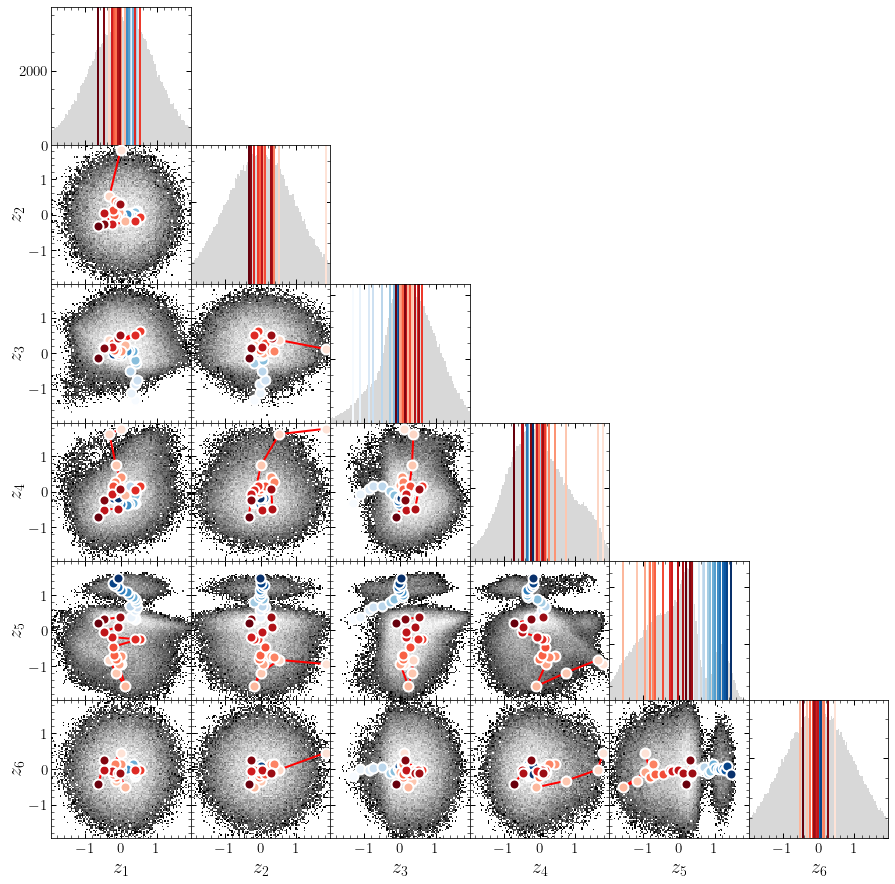

In [10]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0, wspace=0)

n = 6
lim = 1.95
bins = 101
s = 100
lw = 2
grid = np.linspace(-lim,lim,bins)

for i in range(n):
    for j in range(n):
        if i <= j:
            plt.subplot(n,n,i+j*n+1)
            if i == 0 and j != 0:
                plt.ylabel(r'$z_{%i}$' % (j + 1),fontsize=20)
            if j==n-1:
                plt.xlabel(r'$z_{%i}$' % (i + 1),fontsize=20)
            if i!=0:
                plt.tick_params(labelleft=False)
            if j!=(n-1):
                plt.tick_params(labelbottom=False)
                
            if i < j:

                plt.hist2d(latent_use[:,i],latent_use[:,j],bins=[grid,grid],cmin=10,norm=colors.PowerNorm(0.5),cmap='Greys_r',zorder=1)

                x1=[]
                y1=[]
                for k,teff_i in enumerate(teff_grid):
                    mask_i = np.abs(teff_use-teff_i)<10
                    plt.scatter(np.mean(latent_use[:,i][smd_mask2*mask_i]),np.mean(latent_use[:,j][smd_mask2*mask_i]),s=s,color=cmap(k),edgecolors='w',linewidths=lw,zorder=3)
                    x1.append(np.mean(latent_use[:,i][smd_mask2*mask_i]))
                    y1.append(np.mean(latent_use[:,j][smd_mask2*mask_i]))
                mask1 = ~np.isnan(x1)*~np.isnan(y1)
                x1 = np.array(x1)[mask1]
                y1 = np.array(y1)[mask1]
                plt.plot(x1,y1,c='b',lw=lw,zorder=2)

                x2=[]
                y2=[]
                for k,logg_i in enumerate(logg_grid):
                    mask_i = np.abs(logg_use-logg_i)<logg_unc
                    plt.scatter(np.mean(latent_use[:,i][rgb_mask1*mask_i]),np.mean(latent_use[:,j][rgb_mask1*mask_i]),s=s,color=cmap2(k),edgecolors='w',linewidths=lw,zorder=3)
                    x2.append(np.mean(latent_use[:,i][rgb_mask1*mask_i]))
                    y2.append(np.mean(latent_use[:,j][rgb_mask1*mask_i]))
                mask2 = ~np.isnan(x2)*~np.isnan(y2)
                x1 = np.array(x2)[mask2]
                y1 = np.array(y2)[mask2]
                plt.plot(x2,y2,c='r',lw=lw,zorder=2)

                plt.xticks(fontsize=15)
                plt.yticks(fontsize=15)
                plt.xlim(-lim,lim)
                plt.ylim(-lim,lim)

            if i == j:

                plt.hist(latent_use[:,i],color='grey',alpha=0.3,density=False, bins=np.linspace(-lim,lim,100),label='XP/APOGEE cross match')

                for k,teff_i in enumerate(teff_grid):
                    mask_i = np.abs(teff_use-teff_i)<10
                    plt.axvline(np.mean(latent_use[:,i][smd_mask2*mask_i]),lw=lw,color=cmap(k))

                for k,logg_i in enumerate(logg_grid):
                    mask_i = np.abs(logg_use-logg_i)<logg_unc
                    plt.axvline(np.mean(latent_use[:,i][rgb_mask1*mask_i]),lw=lw,color=cmap2(k))
                
                plt.xticks(fontsize=15)
                plt.yticks(fontsize=15)
                plt.xlim(-lim,lim)

plt.savefig('../figures/latent_tracks.png',dpi=400,bbox_inches='tight')
plt.show()

/opt/anaconda3/envs/xp/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/xp/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


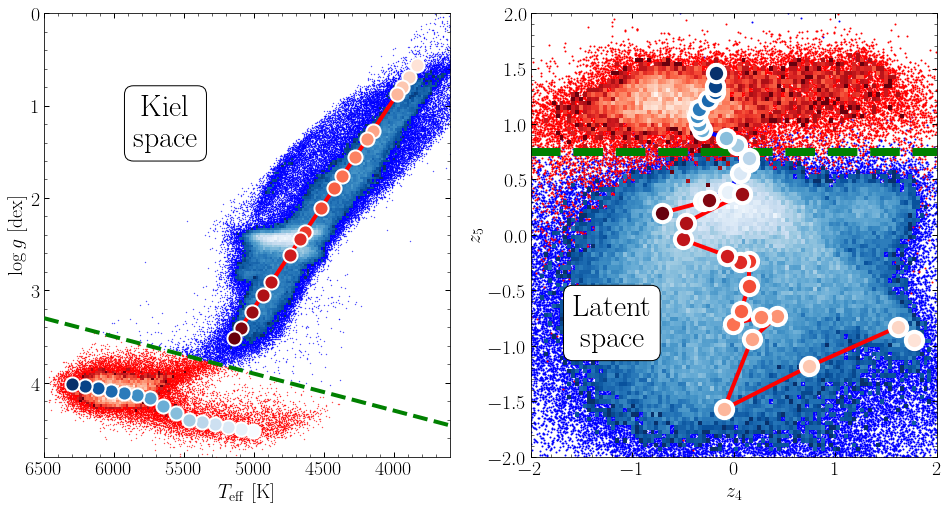

In [11]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

bins=201
s = 200
lw = 2
teff_grid = np.linspace(min(teff_use),max(teff_use),bins)
logg_grid = np.linspace(min(logg_use),max(logg_use),bins)

x = np.linspace(2e3,8e3,101)
ax[0].plot(x,5.9-4*(x/1e4),c='green',lw=2*lw,zorder=5,ls='--')
logg_cut = 5.9 - 4*(teff_use/1e4)

ax[0].hist2d(teff_use[logg_use<logg_cut],logg_use[logg_use<logg_cut],bins=[teff_grid,logg_grid],cmin=20,norm=colors.PowerNorm(0.5),cmap='Blues_r',zorder=2)
ax[0].scatter(teff_use[logg_use<logg_cut],logg_use[logg_use<logg_cut],s=0.1,color='b',zorder=1)

ax[0].hist2d(teff_use[logg_use>=logg_cut],logg_use[logg_use>=logg_cut],bins=[teff_grid,logg_grid],cmin=20,norm=colors.PowerNorm(0.5),cmap='Reds_r',zorder=2)
ax[0].scatter(teff_use[logg_use>=logg_cut],logg_use[logg_use>=logg_cut],s=0.1,color='r',zorder=1)

num_teff = 15
teff_unc = 10
teff_grid = np.linspace(5000,6300,num_teff)
c = np.arange(1,num_teff+1)
cmap = mpl.cm.get_cmap('Blues',num_teff)

x1=[]
y1=[]
for i,teff_i in enumerate(teff_grid):
    mask_i = np.abs(teff_use-teff_i)<10
    ax[0].scatter(np.mean(teff_use[smd_mask2*mask_i]),np.mean(logg_use[smd_mask2*mask_i]),s=s,zorder=4,color=cmap(i),edgecolors='w',linewidths=lw)
    x1.append(np.mean(teff_use[smd_mask2*mask_i]))
    y1.append(np.mean(logg_use[smd_mask2*mask_i]))
mask1 = ~np.isnan(x1)*~np.isnan(y1)
x1 = np.array(x1)[mask1]
y1 = np.array(y1)[mask1]
ax[0].plot(x1,y1,c='b',lw=4)

num_logg = 20
logg_unc = 0.2
logg_grid = np.linspace(0.,3.65,num_logg)
cmap2 = mpl.cm.get_cmap('Reds',num_logg)

x2=[]
y2=[]
for i,logg_i in enumerate(logg_grid):
    mask_i = np.abs(logg_use-logg_i)<logg_unc
    ax[0].scatter(np.mean(teff_use[rgb_mask1*mask_i]),np.mean(logg_use[rgb_mask1*mask_i]),s=s,zorder=5,color=cmap2(i),edgecolors='w',linewidths=lw)
    x2.append(np.mean(teff_use[rgb_mask1*mask_i]))
    y2.append(np.mean(logg_use[rgb_mask1*mask_i]))
mask2 = ~np.isnan(x2)*~np.isnan(y2)
x2 = np.array(x2)[mask2]
y2 = np.array(y2)[mask2]
ax[0].plot(x2,y2,c='r',lw=4)

ax[0].set_xlim(6500,3600)
ax[0].set_ylim(4.8,0)
ax[0].set_ylabel(r'$\log g$ [dex]')
ax[0].set_xlabel(r'$T_{\rm eff}$ [K]')

# NOW PLOT LATENT 

dim1 = 3
dim2 = 4
s = 300
lw = 4

ax[1].axhline(0.75,lw=2*lw,c='green',ls='--',zorder=2)

ax[1].hist2d(latent_use[:,dim1][logg_use<logg_cut],latent_use[:,dim2][logg_use<logg_cut],bins=[grid,grid],cmin=10,norm=colors.PowerNorm(0.5),cmap='Blues_r',zorder=1)
ax[1].scatter(latent_use[:,dim1][logg_use<logg_cut],latent_use[:,dim2][logg_use<logg_cut],s=1,color='b',zorder=0)

ax[1].hist2d(latent_use[:,dim1][logg_use>=logg_cut],latent_use[:,dim2][logg_use>=logg_cut],bins=[grid,grid],cmin=10,norm=colors.PowerNorm(0.5),cmap='Reds_r',zorder=1)
ax[1].scatter(latent_use[:,dim1][logg_use>=logg_cut],latent_use[:,dim2][logg_use>=logg_cut],s=1,color='r',zorder=0)

x1=[]
y1=[]
for k,teff_i in enumerate(teff_grid):
    mask_i = np.abs(teff_use-teff_i)<10
    ax[1].scatter(np.mean(latent_use[:,dim1][smd_mask2*mask_i]),np.mean(latent_use[:,dim2][smd_mask2*mask_i]),s=s,color=cmap(k),edgecolors='w',linewidths=lw,zorder=3)
    x1.append(np.mean(latent_use[:,dim1][smd_mask2*mask_i]))
    y1.append(np.mean(latent_use[:,dim2][smd_mask2*mask_i]))
mask1 = ~np.isnan(x1)*~np.isnan(y1)
x1 = np.array(x1)[mask1]
y1 = np.array(y1)[mask1]
ax[1].plot(x1,y1,c='b',lw=lw,zorder=2)

x2=[]
y2=[]
for k,logg_i in enumerate(logg_grid):
    mask_i = np.abs(logg_use-logg_i)<logg_unc
    ax[1].scatter(np.mean(latent_use[:,dim1][rgb_mask1*mask_i]),np.mean(latent_use[:,dim2][rgb_mask1*mask_i]),s=s,color=cmap2(k),edgecolors='w',linewidths=lw,zorder=3)
    x2.append(np.mean(latent_use[:,dim1][rgb_mask1*mask_i]))
    y2.append(np.mean(latent_use[:,dim2][rgb_mask1*mask_i]))
mask2 = ~np.isnan(x2)*~np.isnan(y2)
x1 = np.array(x2)[mask2]
y1 = np.array(y2)[mask2]
ax[1].plot(x2,y2,c='r',lw=lw,zorder=2)

ax[1].set_xlim(-2,2)
ax[1].set_ylim(-2,2)

ax[1].set_xlabel(r'$z_{%s}$' % (dim1+1),fontsize=20)
ax[1].set_ylabel(r'$z_{%s}$' % (dim2+1),fontsize=20)

bbox=dict(facecolor='w', edgecolor='k', boxstyle='round')
ax[0].text(0.3,0.7,'Kiel\nspace',transform=ax[0].transAxes,fontsize=30,ha='center',bbox=bbox)
ax[1].text(0.2,0.25,'Latent\nspace',transform=ax[1].transAxes,fontsize=30,ha='center',bbox=bbox)

plt.savefig('../figures/kiel_vs_latent.png',dpi=400,bbox_inches='tight')
plt.show()

## Metallicity tracks

In [14]:
# RGB tracks

m_h_unc = 0.2
num_m_h = 10
m_h_grid = np.linspace(-2.5,0.5,num_m_h)[1:]
num_m_h = len(m_h_grid)

teff_unc = 100
num_teff = 8
teff_grid = np.linspace(3200,5200,num_teff)

giant_thresh = logg_use <= (5.9 - 4*(teff_use/1e4))

m_h_mask1 = np.array([[(np.abs(m_h_use-m_h_i)<m_h_unc)*(giant_thresh)*(np.abs(teff_use-teff_i)<teff_unc) for m_h_i in m_h_grid] for teff_i in teff_grid])

giant_metallicity_tracks = np.zeros((num_teff,num_m_h,2))

for i in range(num_teff):
    for j in range(num_m_h):
        teff_ij = np.mean(teff_use[m_h_mask1[i,j]])
        logg_ij = np.mean(logg_use[m_h_mask1[i,j]])
        giant_metallicity_tracks[i,j] = np.array([teff_ij,logg_ij])

/opt/anaconda3/envs/xp/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/xp/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
# MS tracks

m_h_unc = 0.2
num_m_h = 10
m_h_grid = np.linspace(-2.5,0.5,num_m_h)[1:]
num_m_h = len(m_h_grid)

teff_unc = 100
num_teff = 8
teff_grid = np.linspace(4400,6400,num_teff)

ms_thresh = logg_use > (5.9 - 4*(teff_use/1e4))

m_h_mask2 = np.array([[(np.abs(m_h_use-m_h_i)<m_h_unc)*(ms_thresh)*(np.abs(teff_use-teff_i)<teff_unc) for m_h_i in m_h_grid] for teff_i in teff_grid])

ms_metallicity_tracks = np.zeros((num_teff,num_m_h,2))

for i in range(num_teff):
    for j in range(num_m_h):
        teff_ij = np.mean(teff_use[m_h_mask2[i,j]])
        logg_ij = np.mean(logg_use[m_h_mask2[i,j]])
        ms_metallicity_tracks[i,j] = np.array([teff_ij,logg_ij])

/var/folders/ld/y_g0jdyx21j6hq57qf3n8rvm0000gn/T/ipykernel_69702/2929331593.py:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm,ticks=c)


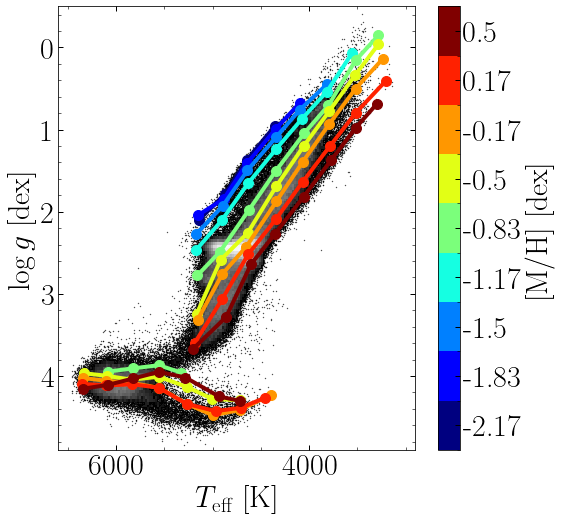

In [16]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
fs = 30

bins=201
s = 200
lw = 4
teff_grid = np.linspace(min(teff),max(teff),bins)
logg_grid = np.linspace(min(logg),max(logg),bins)

ax.hist2d(teff_use,logg_use,bins=[teff_grid,logg_grid],cmin=20,norm=colors.PowerNorm(0.5),cmap='Greys_r',zorder=2)
ax.scatter(teff_use,logg_use,s=0.1,color='k',zorder=1)

# create the new map
c = np.arange(1.,num_m_h+1.)
cmap3 = plt.cm.get_cmap('jet',len(c))
norm = mpl.colors.BoundaryNorm(np.arange(len(c)+1)+0.5,len(c))
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap3)

for i in range(num_m_h):
    teff_track,logg_track = giant_metallicity_tracks[:,i].T
    ax.plot(teff_track,logg_track,marker='o',zorder=4,markersize=10,color=cmap3(i),linestyle='-',lw=lw) 

for i in range(num_m_h):
    teff_track,logg_track = ms_metallicity_tracks[:,i].T
    ax.plot(teff_track,logg_track,marker='o',zorder=4,markersize=10,color=cmap3(i),linestyle='-',lw=lw) 

ax.set_xlim(6600,2900)
ax.set_ylim(4.9,-0.5)
ax.set_ylabel(r'$\log g$ [dex]',fontsize=fs)
ax.set_xlabel(r'$T_{\rm eff}$ [K]',fontsize=fs)
ax.tick_params(labelsize=fs)

cbar = fig.colorbar(sm,ticks=c)
cbar.set_ticklabels(np.round(m_h_grid,2),fontsize=fs)
cbar.set_label(r'[M/H] [dex]',fontsize=fs)
plt.savefig('../figures/kiel_metallicity_tracks.png',dpi=400,bbox_inches='tight')
plt.show()

/opt/anaconda3/envs/xp/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/xp/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


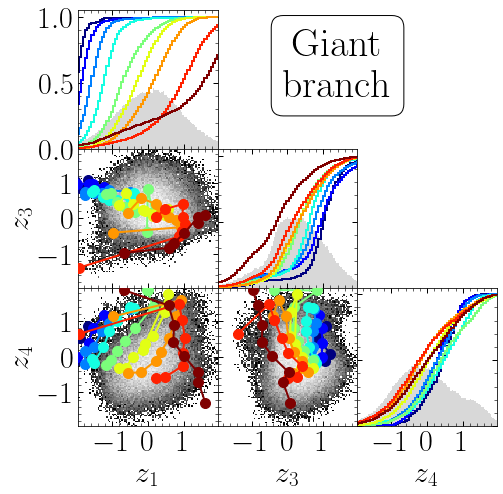

In [17]:
fig = plt.figure(figsize=(7.5,7.5))
fig.subplots_adjust(hspace=0, wspace=0)
fs=30

dims = np.array([1,3,4])-1
n = len(dims)
lim = 1.95
bins = 101
s = 100
lw = 2
grid = np.linspace(-lim,lim,bins)

for i in range(n):
    for j in range(n):
        if i <= j:
            plt.subplot(n,n,i+j*n+1)
            if i == 0 and j != 0:
                plt.ylabel(r'$z_{%i}$' % (dims[j] + 1),fontsize=fs)
            if j==n-1:
                plt.xlabel(r'$z_{%i}$' % (dims[i] + 1),fontsize=fs)
            if i!=0:
                plt.tick_params(labelleft=False)
            if j!=(n-1):
                plt.tick_params(labelbottom=False)
                
            if i < j:

                plt.hist2d(latent_use[:,dims[i]],latent_use[:,dims[j]],bins=[grid,grid],cmin=10,norm=colors.PowerNorm(0.5),cmap='Greys_r',zorder=1)

                metallicity_tracks = np.zeros((num_teff,num_m_h,2))
                for ii in range(num_teff):
                    for jj in range(num_m_h):
                        l_i = np.mean(latent_use[:,dims[i]][m_h_mask1[ii,jj]])
                        l_j = np.mean(latent_use[:,dims[j]][m_h_mask1[ii,jj]])
                        metallicity_tracks[ii,jj] = np.array([l_i,l_j])

                for k in range(num_m_h):
                    l_i_track,l_j_track = metallicity_tracks[:,k].T
                    plt.plot(l_i_track,l_j_track,marker='o',zorder=3,markersize=10,color=cmap3(k),linestyle='-',lw=lw) 

                plt.xticks(fontsize=fs)
                plt.yticks(fontsize=fs)
                plt.xlim(-lim,lim)
                plt.ylim(-lim,lim)

            if i == j:

                plt.hist(latent_use[:,dims[i]],color='grey',alpha=0.3,density=True, bins=np.linspace(-lim,lim,100),label='XP/APOGEE cross match')

                for k in range(num_m_h):
                    mask = (np.abs(m_h_use-m_h_grid[k])<m_h_unc)*(giant_thresh)
                    _,_,patches=plt.hist(latent_use[:,dims[i]][mask],color=cmap3(k),linestyle='-',lw=lw,histtype='step', bins=np.linspace(-lim-1,lim+1,100), density=True, cumulative=True) 
                    patches[0].set_xy(patches[0].get_xy()[:-1])

                plt.xticks(fontsize=fs)
                plt.yticks(fontsize=fs)
                plt.xlim(-lim,lim)

plt.text(-2.5,2.5,'Giant\nbranch',fontsize=40,ha='center',bbox=bbox)

plt.savefig('../figures/latent_giant_metallicity_tracks.png',dpi=400,bbox_inches='tight')
plt.show()

/opt/anaconda3/envs/xp/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/xp/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


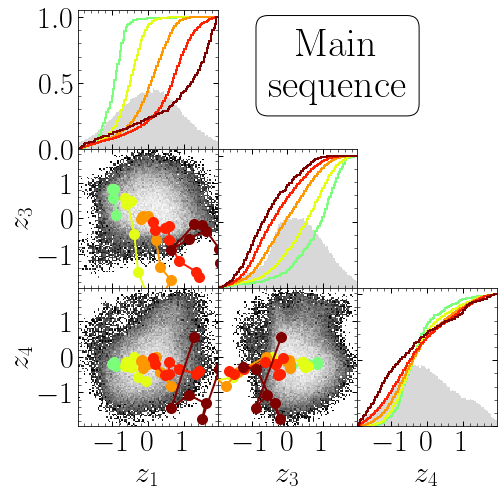

In [18]:
fig = plt.figure(figsize=(7.5,7.5))
fig.subplots_adjust(hspace=0, wspace=0)
fs=30

dims = np.array([1,3,4])-1
n = len(dims)
lim = 1.95
bins = 101
s = 100
lw = 2
grid = np.linspace(-lim,lim,bins)

for i in range(n):
    for j in range(n):
        if i <= j:
            plt.subplot(n,n,i+j*n+1)
            if i == 0 and j != 0:
                plt.ylabel(r'$z_{%i}$' % (dims[j] + 1),fontsize=fs)
            if j==n-1:
                plt.xlabel(r'$z_{%i}$' % (dims[i] + 1),fontsize=fs)
            if i!=0:
                plt.tick_params(labelleft=False)
            if j!=(n-1):
                plt.tick_params(labelbottom=False)
                
            if i < j:

                plt.hist2d(latent_use[:,dims[i]],latent_use[:,dims[j]],bins=[grid,grid],cmin=10,norm=colors.PowerNorm(0.5),cmap='Greys_r',zorder=1)

                metallicity_tracks = np.zeros((num_teff,num_m_h,2))
                for ii in range(num_teff):
                    for jj in range(num_m_h):
                        l_i = np.mean(latent_use[:,dims[i]][m_h_mask2[ii,jj]])
                        l_j = np.mean(latent_use[:,dims[j]][m_h_mask2[ii,jj]])
                        metallicity_tracks[ii,jj] = np.array([l_i,l_j])

                for k in range(4,num_m_h):
                    l_i_track,l_j_track = metallicity_tracks[:,k].T
                    plt.plot(l_i_track,l_j_track,marker='o',zorder=3,markersize=10,color=cmap3(k),linestyle='-',lw=lw) 

                plt.xticks(fontsize=fs)
                plt.yticks(fontsize=fs)
                plt.xlim(-lim,lim)
                plt.ylim(-lim,lim)

            if i == j:

                plt.hist(latent_use[:,dims[i]],color='grey',alpha=0.3,density=True, bins=np.linspace(-lim,lim,100),label='XP/APOGEE cross match')

                for k in range(4,num_m_h):
                    mask = (np.abs(m_h_use-m_h_grid[k])<m_h_unc)*(ms_thresh)
                    _,_,patches=plt.hist(latent_use[:,dims[i]][mask],color=cmap3(k),linestyle='-',lw=lw,histtype=u'step', bins=grid, density=True, cumulative=True) 
                    patches[0].set_xy(patches[0].get_xy()[:-1])
                    
                plt.xticks(fontsize=fs)
                plt.yticks(fontsize=fs)
                plt.xlim(-lim,lim)

plt.text(-2.5,2.5,'Main\nsequence',fontsize=40,ha='center',bbox=bbox)

plt.savefig('../figures/latent_ms_metallicity_tracks.png',dpi=400,bbox_inches='tight')
plt.show()